## 1. Import & load libraries

In [71]:
%pip cache purge
# %pip uninstall matplotlib -y
# %pip uninstall ydata-profiling -y

%pip install mne
%pip install matplotlib
%pip install numpy
%pip install pandas


Files removed: 0
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.python.org/simple
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.python.org/simple
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.python.org/simple
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.python.org/simple
Note: you may need to restart the kernel to use updated packages.


In [72]:
pip list


Package                Version
---------------------- ------------------------------------
annotated-types        0.7.0
appdirs                1.4.4
asgiref                3.8.1
asttokens              2.4.1
attrs                  21.2.0
autobahn               21.11.1
Automat                20.2.0
Babel                  2.8.0
backcall               0.2.0
base58                 1.0.3
bcrypt                 3.2.0
beautifulsoup4         4.10.0
beniget                0.4.1
blinker                1.4
bottle                 0.12.25
Brotli                 1.0.9
cbor                   1.0.0
certifi                2020.6.20
cffi                   1.15.0
chardet                4.0.0
chrome-gnome-shell     0.0.0
click                  8.0.3
cloud-init             23.3.3
colorama               0.4.4
comm                   0.2.2
command-not-found      0.3
configobj              5.0.6
constantly             15.1.0
contourpy              1.3.1
cryptography           3.4.8
cupshelpers            1.0
cy

In [73]:
import mne

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import re
import warnings
import glob

from mne.datasets import eegbci
from mne.io import read_raw_edf
from mne.io import concatenate_raws

from typing import List

# from mne.preprocessing import ICA

# from time import time


In [87]:
warnings.filterwarnings("ignore", message="FigureCanvasAgg is non-interactive, and thus cannot be shown")
warnings.filterwarnings("ignore", category=RuntimeWarning, message="Channel locations not available.*")


## 2. Load data

### Description of data:

The experimental runs were:

- Baseline, eyes open
- Baseline, eyes closed
- Task 1 (open and close left or right fist)
- Task 2 (imagine opening and closing left or right fist)
- Task 3 (open and close both fists or both feet)
- Task 4 (imagine opening and closing both fists or both feet)

Each annotation includes one of three codes (T0, T1, or T2):

- T0 corresponds to rest
- T1 corresponds to onset of motion (real or imagined) of
        the left fist (in runs 3, 4, 7, 8, 11, and 12)
        both fists (in runs 5, 6, 9, 10, 13, and 14)
- T2 corresponds to onset of motion (real or imagined) of
        the right fist (in runs 3, 4, 7, 8, 11, and 12)
        both feet (in runs 5, 6, 9, 10, 13, and 14)

| Run       | Task                                |
|-----------|-------------------------------------|
| 1         | Baseline, eyes open                 |
| 2         | Baseline, eyes closed               |
| 3, 7, 11  | Motor execution: left vs right hand |
| 4, 8, 12  | Motor imagery: left vs right hand   |
| 5, 9, 13  | Motor execution: hands vs feet      |
| 6, 10, 14 | Motor imagery: hands vs feet        |


The EEGs were recorded from 64 electrodes as per the international system (excluding electrodes Nz, F9, F10, FT9, FT10, A1, A2, TP9, TP10, P9, and P10)

<img width=100% src=../images/EGG_64.png>

<img width=100% src="https://physionet.org/files/eegmmidb/1.0.0/64_channel_sharbrough.png">


In [75]:
def rename_channels(raw):
    """
    Rename channels in an MNE raw object to match the standard montage with 64 electrods.
    Removes non-standard characters (e.g., '.', '..') and ensures consistency with MNE’s standard channel naming conventions.
    """
    original_names = raw.ch_names

    # Cleaning function: removes ".", ".." and other non-alphanumeric characters
    def clean_name(name):
        return re.sub(r'[^A-Za-z0-9]', '', name)  # Removes any non-alphanumeric characters

    # Create a mapping dictionary for renaming
    mapping = {old_name: clean_name(old_name) for old_name in original_names if old_name != clean_name(old_name)}

    # Rename channels and print changes
    if mapping:
        print("\nRenaming channels:")
        for old_name, new_name in mapping.items():
            print(f"  {old_name} -> {new_name}")
        raw.rename_channels(mapping)
    else:
        print("No channels needed renaming.")

    return raw



In [76]:
def load_data(subjects: List[int], runs: List[int], data_dir="../data/files/"):
    """
    Load and preprocess EEG data for given subjects and runs.
    """
    all_raws = []

    for subject in subjects:
        print(f"\n=== Loading data for subject {subject} ===")
        try:
            # Download data to the specified directory
            raw_fnames = mne.datasets.eegbci.load_data(subject, runs, path=data_dir)
            raws = [mne.io.read_raw_edf(f, preload=True, verbose=True) for f in raw_fnames]  
            raw = mne.concatenate_raws(raws)
        except Exception as e:
            warnings.warn(f"Skipping subject {subject} due to an error: {e}")
            continue

        # Rename channels to match the standard montage
        rename_channels(raw)

        # Set standard montage
        try:
            raw.set_montage("standard_1005", on_missing="ignore")
        except Exception as e:
            warnings.warn(f"Could not set montage for subject {subject}: {e}")

        # Extract events from annotations
        try:
            events, _ = mne.events_from_annotations(raw)
            new_labels_events = {1: 'rest', 2: 'action_hand', 3: 'action_feet'}  # Custom labels
            new_annot = mne.annotations_from_events(events=events, event_desc=new_labels_events, 
                                                    sfreq=raw.info['sfreq'], orig_time=raw.info['meas_date'])
            raw.set_annotations(new_annot)
        except Exception as e:
            warnings.warn(f"Could not update event labels for subject {subject}: {e}")

        all_raws.append(raw)

    if not all_raws:
        raise ValueError("No valid EEG data loaded. Check subject and run IDs.")

    # Concatenate all subjects' data
    return mne.concatenate_raws(all_raws)


In [77]:
subjects = [1, 2]
# subjects = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
runs = 3

raw_data = load_data(subjects, runs)



=== Loading data for subject 1 ===
Extracting EDF parameters from /home/dgerwig-/OneDrive/code_dgerwig/42_Cursus_Outer_Core/vortex/42_vortex/data/files/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...

Renaming channels:
  Fc5. -> Fc5
  Fc3. -> Fc3
  Fc1. -> Fc1
  Fcz. -> Fcz
  Fc2. -> Fc2
  Fc4. -> Fc4
  Fc6. -> Fc6
  C5.. -> C5
  C3.. -> C3
  C1.. -> C1
  Cz.. -> Cz
  C2.. -> C2
  C4.. -> C4
  C6.. -> C6
  Cp5. -> Cp5
  Cp3. -> Cp3
  Cp1. -> Cp1
  Cpz. -> Cpz
  Cp2. -> Cp2
  Cp4. -> Cp4
  Cp6. -> Cp6
  Fp1. -> Fp1
  Fpz. -> Fpz
  Fp2. -> Fp2
  Af7. -> Af7
  Af3. -> Af3
  Afz. -> Afz
  Af4. -> Af4
  Af8. -> Af8
  F7.. -> F7
  F5.. -> F5
  F3.. -> F3
  F1.. -> F1
  Fz.. -> Fz
  F2.. -> F2
  F4.. -> F4
  F6.. -> F6
  F8.. -> F8
  Ft7. -> Ft7
  Ft8. -> Ft8
  T7.. -> T7
  T8.. -> T8
  T9.. -> T9
  T10. -> T10
  Tp7. -> Tp7
  Tp8. -> Tp8
  P7..

In [78]:
def summarize_edf_files(data_dir="../data/files/"):
    """
    Recursively summarize the contents of all .edf files in the given directory.
    """
    edf_files = glob.glob(os.path.join(data_dir, "**/*.edf"), recursive=True)
    
    if not edf_files:
        print("No EDF files found in the directory or subdirectories.")
        return
    
    print(f"Found {len(edf_files)} EDF files in {data_dir}**:\n")
    
    for edf_file in edf_files:
        try:
            raw = mne.io.read_raw_edf(edf_file, preload=False, verbose=False)
            info = raw.info
            duration = raw.times[-1] / info['sfreq']  # Total duration in seconds
            
            rel_path = os.path.relpath(edf_file, data_dir)  # Get relative path for better readability
            
            print(f"File: {rel_path}")
            print(f"  - Channels: {len(info['ch_names'])}")
            print(f"  - Sampling Frequency: {info['sfreq']} Hz")
            print(f"  - Duration: {duration:.2f} seconds")
            print("-" * 40)
        
        except Exception as e:
            print(f"Error reading {edf_file}: {e}")

# Run the function
summarize_edf_files()


Found 2 EDF files in ../data/files/**:

File: MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R03.edf
  - Channels: 64
  - Sampling Frequency: 160.0 Hz
  - Duration: 0.78 seconds
----------------------------------------
File: MNE-eegbci-data/files/eegmmidb/1.0.0/S002/S002R03.edf
  - Channels: 64
  - Sampling Frequency: 160.0 Hz
  - Duration: 0.77 seconds
----------------------------------------


In [79]:
print(raw_data.info)


<Info | 9 non-empty values
 bads: []
 ch_names: Fc5, Fc3, Fc1, Fcz, Fc2, Fc4, Fc6, C5, C3, C1, Cz, C2, C4, C6, ...
 chs: 64 EEG
 custom_ref_applied: False
 dig: 39 items (3 Cardinal, 36 EEG)
 highpass: 0.0 Hz
 lowpass: 80.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 64
 projs: []
 sfreq: 160.0 Hz
 subject_info: <subject_info | his_id: X, sex: 0, last_name: X>
>


In [80]:
# Select only EEG channels
picks = mne.pick_types(raw_data.info, meg=True, eeg=True, stim=False, eog=False, exclude='bads')
print(picks)


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]


In [81]:
eegbci.standardize(raw_data)


In [82]:
montage = mne.channels.make_standard_montage('standard_1005')
raw_data.set_montage(montage)
# raw_data.set_montage(montage, on_missing='ignore')


<RawEDF | S001R03.edf, 64 x 39680 (248.0 s), ~19.5 MiB, data loaded>

In [83]:
# Show the events
events, event_id = mne.events_from_annotations(raw_data)
print(raw_data.info)
print(raw_data.annotations)
print(raw_data.annotations.description)
print(raw_data.annotations.onset)
print(raw_data.annotations.orig_time)
print(events)
print(event_id)


Used Annotations descriptions: [np.str_('action_feet'), np.str_('action_hand'), np.str_('rest')]
<Info | 9 non-empty values
 bads: []
 ch_names: FC5, FC3, FC1, FCz, FC2, FC4, FC6, C5, C3, C1, Cz, C2, C4, C6, ...
 chs: 64 EEG
 custom_ref_applied: False
 dig: 67 items (3 Cardinal, 64 EEG)
 highpass: 0.0 Hz
 lowpass: 80.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 64
 projs: []
 sfreq: 160.0 Hz
 subject_info: <subject_info | his_id: X, sex: 0, last_name: X>
>
<Annotations | 62 segments: BAD boundary (1), EDGE boundary (1), ...>
['rest' 'action_feet' 'rest' 'action_hand' 'rest' 'action_hand' 'rest'
 'action_feet' 'rest' 'action_feet' 'rest' 'action_hand' 'rest'
 'action_hand' 'rest' 'action_feet' 'rest' 'action_hand' 'rest'
 'action_feet' 'rest' 'action_feet' 'rest' 'action_hand' 'rest'
 'action_hand' 'rest' 'action_feet' 'rest' 'action_hand' 'rest'
 'BAD boundary' 'EDGE boundary' 'action_hand' 'rest' 'action_feet' 'rest'
 'action_feet' 'rest' 'action_hand' 'rest' 'action_hand' 'rest'


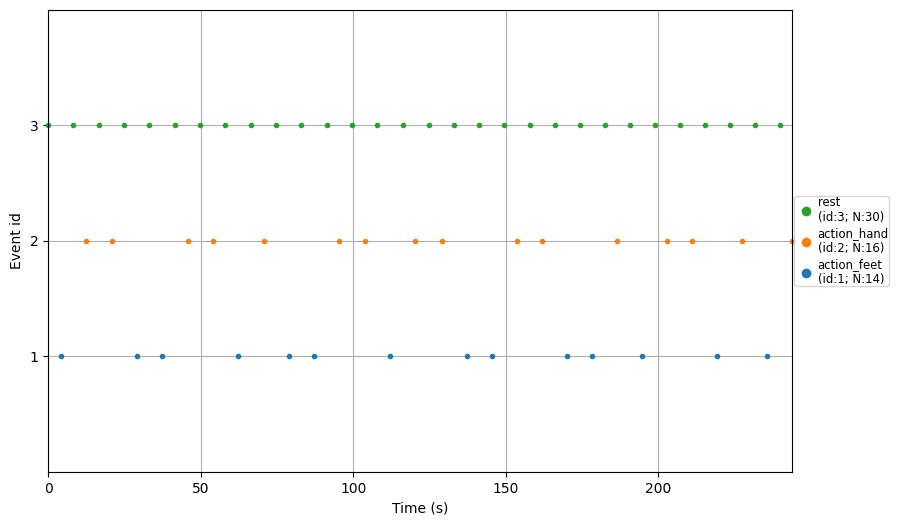

In [84]:
plt.rcParams["figure.figsize"] = (12, 6)  
mne.viz.plot_events(events, sfreq=raw_data.info['sfreq'], 
                     first_samp=raw_data.first_samp, event_id=event_id)
plt.show()


### Show PSD Power Spectral Density (Plot power or amplitude spectra)

Loading ../data/files/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R03.edf
Extracting EDF parameters from /home/dgerwig-/OneDrive/code_dgerwig/42_Cursus_Outer_Core/vortex/42_vortex/data/files/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Loading ../data/files/MNE-eegbci-data/files/eegmmidb/1.0.0/S002/S002R03.edf
Extracting EDF parameters from /home/dgerwig-/OneDrive/code_dgerwig/42_Cursus_Outer_Core/vortex/42_vortex/data/files/MNE-eegbci-data/files/eegmmidb/1.0.0/S002/S002R03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Effective window size : 12.800 (s)
Plotting power spectral density (dB=True).


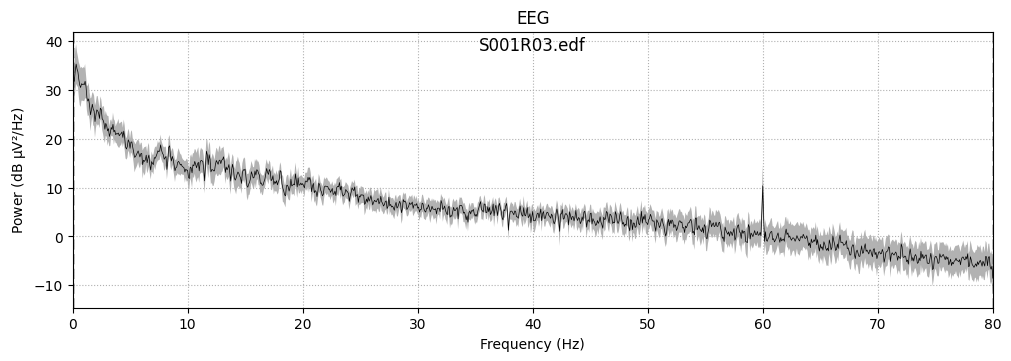

Effective window size : 12.800 (s)
Plotting power spectral density (dB=True).


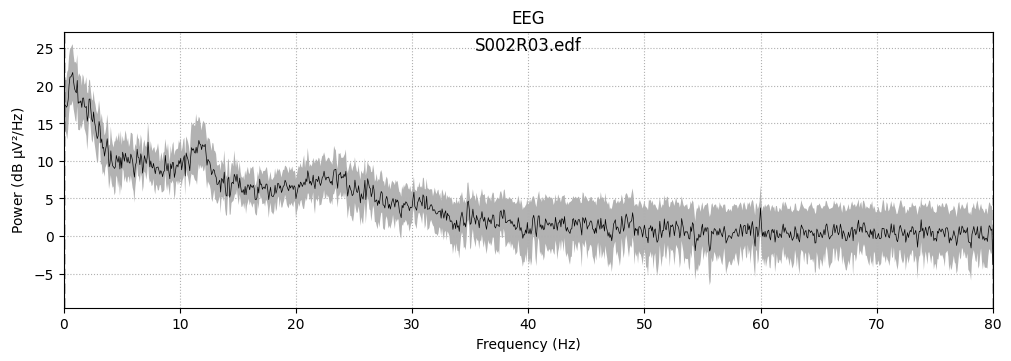

In [85]:
data_dir = "../data/files/"

files = [os.path.join(root, file) for root, _, files in os.walk(data_dir) for file in files if file.endswith('.edf')]

raw_data_list = []

for file in files:
    print(f"Loading {file}")
    raw = mne.io.read_raw_edf(file, preload=True)
    raw_data_list.append(raw)

for i, raw_data in enumerate(raw_data_list):
    fig = raw_data.compute_psd().plot(average=True)
    
    plt.text(0.5, 0.95, os.path.basename(files[i]), ha='center', va='center', transform=fig.axes[0].transAxes, fontsize=12)
    
    plt.show()


Effective window size : 12.800 (s)
Plotting power spectral density (dB=True).


/tmp/ipykernel_1545231/132653761.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw_data.compute_psd().plot()


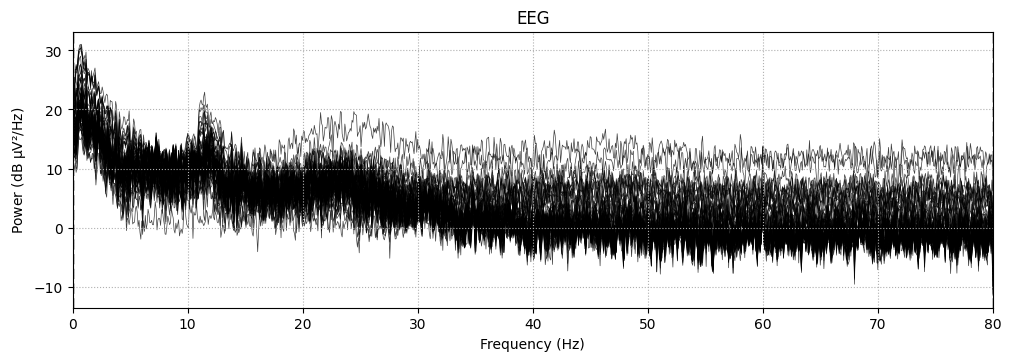

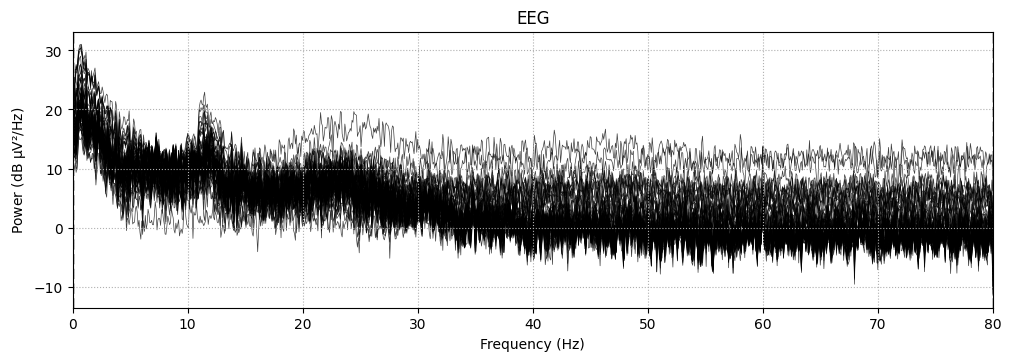

In [86]:
raw_data.compute_psd().plot()
